In [1]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.callbacks import TensorBoard
import numpy as np
from keras import backend as K
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.models import model_from_json


input_encoder = Input(shape=(28, 28, 1))
input_decoder = Input(shape=(4, 4, 4))

with open('decoder.json', 'r') as f:
    decoder = model_from_json(f.read())
    decoder.load_weights("decoder.h5")
    
with open('encoder.json', 'r') as f:
    encoder = model_from_json(f.read())
    encoder.load_weights("encoder.h5")
    
with open('autoencoder.json', 'r') as f:
    autoencoder = model_from_json(f.read())
    autoencoder.load_weights("autoencoder.h5")

/home/ganimedes/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


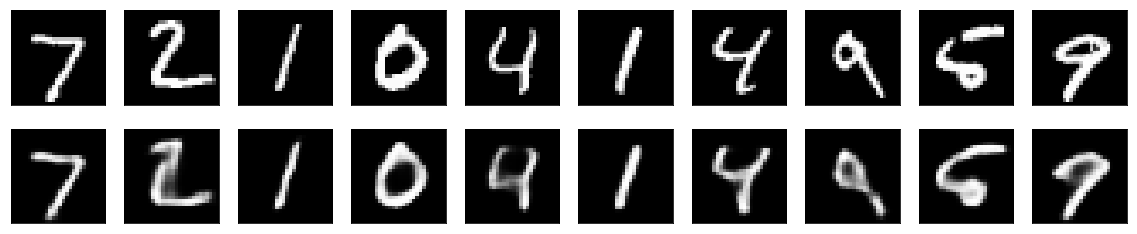

In [2]:
(x_train, y_train), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [3]:
data_x = encoder.predict(x_train)

In [12]:
import matplotlib.pyplot as plt

discriminator_input_dim = (74,)
generator_input_dim = (110,)
batch_size = 128
epochs = 50000

discriminator_input = Input(shape=discriminator_input_dim)
generator_input = Input(shape=generator_input_dim)
input_double = Input(shape=generator_input_dim)

def custom_activation(x):
    return (K.sigmoid(x) * 3) 

def discriminator(x):
    hidden1 = Dense(256, activation="relu")(x)
    hidden2 = Dense(256, activation="relu")(hidden1)
    return Dense(1, activation="sigmoid")(hidden2)
    
def generator(x):
    hidden1 = Dense(256, activation="relu")(x)
    hidden2 = Dense(256, activation="relu")(hidden1)
    return Dense(64, activation=custom_activation)(hidden2)

def random_input_batch_with_class(labels):
    result = []
    for a in labels:
        noise = np.random.normal(0, 1, (100))
        cond = np.zeros(10)
        cond[a] = 1
        result.append(numpy.concatenate([noise, cond]))
    return np.array(result)

generator_model = Model(generator_input, generator(generator_input))
discriminator_model = Model(discriminator_input, discriminator(discriminator_input))
discriminator_model.compile(loss='binary_crossentropy', optimizer="adadelta", metrics=['accuracy'])
generator_model.compile(loss='binary_crossentropy', optimizer="adadelta")

img = generator_model(input_double)
discriminator_model.trainable = False
valid = discriminator_model(img)

double_model = Model(input_double, valid)
double_model.compile(loss='binary_crossentropy', optimizer="adadelta")

X_train = data_x.reshape(60000, 64)
half_batch = int(batch_size / 2)
for epoch in range(epochs):  
    if epoch % 1000 == 1:
        n = 10
        plt.figure(figsize=(20, 4))
        for i in range(n):
            ax = plt.subplot(2, n, i + 1)
            plt.imshow(decoder.predict(generator_model.predict(random_input_batch_with_class([0])).reshape((1,4,4,4))).reshape(28, 28))
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            plt.gray()
        plt.show()
    idx = np.random.randint(0, X_train.shape[0], half_batch)
    labels = y_train[idx]
    imgs = numpy.concatenate([X_train[idx], labels])
    noise = random_input_batch_with_class(labels)
    gen_imgs = generator_model.predict(noise)

    d_loss_real = discriminator_model.train_on_batch(imgs, np.ones((half_batch, 1)))
    d_loss_fake = discriminator_model.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    noise = random_input_batch_with_class(np.concatenate([labels, labels]))
    g_loss = double_model.train_on_batch(noise, np.ones((batch_size, 1)))

    print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

ValueError: Dimensions must be equal, but are 64 and 74 for 'model_10/dense_28/MatMul' (op: 'MatMul') with input shapes: [?,64], [74,256].

[1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
